In [44]:
#Imports 
import requests
import json
import pandas as pd
#


In [45]:
# Prepare query URL to fetch JSON data from Maryland Government site
query_url = 'https://data.montgomerycountymd.gov/api/views/mmzv-x632/rows.json?accessType=DOWNLOAD'

# Fetch data using requests
response = requests.get(query_url)

In [46]:
# Validate response status
if response.status_code == 200 :
    json_data = response.json()
else :
    print(f'URL returned response code {response.status_code}')

In [47]:
# Prepare a dictionary to create a DataFrame. Current response JSON contains 
# column names in meta attribute. Create list of dictionary with columns as keys
dictionary_list = json_data['meta']['view']['columns']
print(dictionary_list)

[{'id': -1, 'name': 'sid', 'dataTypeName': 'meta_data', 'fieldName': ':sid', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']}, {'id': -1, 'name': 'id', 'dataTypeName': 'meta_data', 'fieldName': ':id', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']}, {'id': -1, 'name': 'position', 'dataTypeName': 'meta_data', 'fieldName': ':position', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']}, {'id': -1, 'name': 'created_at', 'dataTypeName': 'meta_data', 'fieldName': ':created_at', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']}, {'id': -1, 'name': 'created_meta', 'dataTypeName': 'meta_data', 'fieldName': ':created_meta', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']}, {'id': -1, 'name': 'updated_at', 'dataTypeName': 'meta_data', 'fieldName': ':updated_at', 'position': 0, 'renderTypeName': 'meta_data', 'format': {}, 'flags': ['hidden']

In [48]:
# Extract column names through list comprehension
column_names = [dictionary['name'] for dictionary in dictionary_list][8:-9]
print(column_names)

['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type', 'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Name', 'Off-Road Description', 'Municipality', 'Related Non-Motorist', 'Collision Type', 'Weather', 'Surface Condition', 'Light', 'Traffic Control', 'Driver Substance Abuse', 'Non-Motorist Substance Abuse', 'Person ID', 'Driver At Fault', 'Injury Severity', 'Circumstance', 'Driver Distracted By', 'Drivers License State', 'Vehicle ID', 'Vehicle Damage Extent', 'Vehicle First Impact Location', 'Vehicle Body Type', 'Vehicle Movement', 'Vehicle Going Dir', 'Speed Limit', 'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year', 'Vehicle Make', 'Vehicle Model', 'Latitude', 'Longitude']


In [49]:
# Extract rows from JSON and put it in a list
rows = []
for list_data in json_data['data']:
    data = list_data[8:-9]
    rows.append({column:value for column, value in zip(column_names,data)})
# Print first two records
print(json.dumps(rows[0:2], indent=4))

[
    {
        "Report Number": "DM8479000T",
        "Local Case Number": "210020119",
        "Agency Name": "Takoma Park Police Depart",
        "ACRS Report Type": "Property Damage Crash",
        "Crash Date/Time": "2021-05-27T19:40:00",
        "Route Type": null,
        "Road Name": null,
        "Cross-Street Name": null,
        "Off-Road Description": "IN PARKING LOT",
        "Municipality": null,
        "Related Non-Motorist": null,
        "Collision Type": "OTHER",
        "Weather": "CLEAR",
        "Surface Condition": null,
        "Light": "DAYLIGHT",
        "Traffic Control": "NO CONTROLS",
        "Driver Substance Abuse": "NONE DETECTED",
        "Non-Motorist Substance Abuse": null,
        "Person ID": "CF61C6EB-61C4-4627-9767-635D2F0174A6",
        "Driver At Fault": "No",
        "Injury Severity": "NO APPARENT INJURY",
        "Circumstance": "N/A",
        "Driver Distracted By": "UNKNOWN",
        "Drivers License State": "MD",
        "Vehicle ID": "D3F

In [50]:
# Create a DataFrame of crashes
df_crashes = pd.DataFrame(rows)
display(df_crashes.head())
display(df_crashes.tail())

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,Vehicle Movement,Vehicle Going Dir,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude
0,DM8479000T,210020119,Takoma Park Police Depart,Property Damage Crash,2021-05-27T19:40:00,None,None,None,IN PARKING LOT,None,...,PARKED,None,0,No,Yes,2017,HINO,TWK,38.98765667,-76.987545
1,MCP2970000R,15045937,MONTGOMERY,Property Damage Crash,2015-09-11T13:29:00,None,None,None,Parking Lot: \n2525 Ennalls Ave,None,...,PARKING,South,5,No,No,2012,TOYOTA,SU,39.03991652,-77.05364898
2,MCP20160036,180040948,Montgomery County Police,Property Damage Crash,2018-08-17T14:25:00,None,None,None,PARKING LOT OF 16246 FREDERICK RD,None,...,BACKING,West,15,No,No,2015,MAZD,TK,38.743373,-77.54699707
3,EJ7879003C,230048975,Gaithersburg Police Depar,Injury Crash,2023-08-11T18:00:00,None,None,None,1 N SUMMIT DRIVE,None,...,MOVING CONSTANT SPEED,Unknown,15,No,No,2018,RAM,TK,39.14587303,-77.19194047
4,MCP2967004Y,230070277,Montgomery County Police,Property Damage Crash,2023-12-06T18:42:00,Maryland (State),CONNECTICUT AVE,BALTIMORE ST,None,KENSINGTON,...,MOVING CONSTANT SPEED,South,35,No,No,2017,AUDI,A3,39.02517017,-77.07633333


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,Vehicle Movement,Vehicle Going Dir,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude
185293,MCP3040006M,240042875,MONTGOMERY,Property Damage Crash,2024-09-09T20:00:00,Maryland (State) Route,GEORGIA AVE,EMORY LA,None,None,...,Moving Constant Speed,None,45,No,No,2008,HONDA,CR-V,39.12611172,-77.0721996
185294,MCP30760045,240044327,MONTGOMERY,Injury Crash,2024-09-17T16:41:00,Interstate (State),IS 270 LOCAL LANES (NB),None,None,None,...,Stopped in Traffic,Northbound,55,No,No,2019,TOYOTA,COROLLA,39.11485928,-77.19158805
185295,MCP241100DT,240045307,MONTGOMERY,Injury Crash,2024-09-23T07:25:00,County Route,ROCKING HORSE RD,GAYNOR RD RANDOLPH RD RANDOLPH RD (WB/L),None,None,...,Turning Left,Westbound,35,No,No,2010,HONDA,ODYSSEY,39.053902,-77.09432717
185296,MCP2844007X,240044414,MONTGOMERY,Property Damage Crash,2024-09-18T07:55:00,County Route,RANDOLPH RD,None,None,None,...,Slowing or Stopping,Eastbound,40,No,No,2008,NISSAN,ALTIMA,39.06308239,-77.04087984
185297,MCP3068005R,240044334,MONTGOMERY,Property Damage Crash,2024-09-17T17:37:00,Maryland (State) Route,WISCONSIN AVE,LELAND ST,None,None,...,Moving Constant Speed,Northbound,35,No,No,2021,THOMAS BUILT,SCHOOL BUS,38.9800724,-77.09206294


In [51]:
# Display columns
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185298 entries, 0 to 185297
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Report Number                  185298 non-null  object
 1   Local Case Number              185298 non-null  object
 2   Agency Name                    185298 non-null  object
 3   ACRS Report Type               185298 non-null  object
 4   Crash Date/Time                185298 non-null  object
 5   Route Type                     167136 non-null  object
 6   Road Name                      166522 non-null  object
 7   Cross-Street Name              161184 non-null  object
 8   Off-Road Description           17125 non-null   object
 9   Municipality                   156182 non-null  object
 10  Related Non-Motorist           5920 non-null    object
 11  Collision Type                 185298 non-null  object
 12  Weather                        185298 non-nu

In [52]:
# Create a focused DataFrame with limited columns
required_columns = ['Report Number','Crash Date/Time','Weather',
                    'Surface Condition','Injury Severity','Vehicle ID',
                    'Vehicle Year', 'Vehicle Make', 'Vehicle Model', 'Latitude', 'Longitude', 'ACRS Report Type']

# Create focused DataFrame
df_focused_crashes = df_crashes[required_columns].copy()

display(df_focused_crashes.head())
display(df_focused_crashes.tail())

,Report Number,Crash Date/Time,Weather,Surface Condition,Injury Severity,Vehicle ID,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,ACRS Report Type
0,DM8479000T,2021-05-27T19:40:00,CLEAR,None,NO APPARENT INJURY,D3F480EE-638B-459A-BC20-533741BC4F76,2017,HINO,TWK,38.98765667,-76.987545,Property Damage Crash
1,MCP2970000R,2015-09-11T13:29:00,CLEAR,None,NO APPARENT INJURY,14ECEFCD-3A58-4991-A9C6-A9D5CA54B419,2012,TOYOTA,SU,39.03991652,-77.05364898,Property Damage Crash
2,MCP20160036,2018-08-17T14:25:00,CLEAR,None,NO APPARENT INJURY,995C9706-91EC-48FC-8D2A-31759590E3EA,2015,MAZD,TK,38.743373,-77.54699707,Property Damage Crash
3,EJ7879003C,2023-08-11T18:00:00,CLEAR,None,NO APPARENT INJURY,EDF71D99-8A86-4CCD-BD22-3F32076A134A,2018,RAM,TK,39.14587303,-77.19194047,Injury Crash
4,MCP2967004Y,2023-12-06T18:42:00,CLEAR,DRY,NO APPARENT INJURY,9870F867-5BC8-4ABB-BA69-A2E515C416CD,2017,AUDI,A3,39.02517017,-77.07633333,Property Damage Crash


,Report Number,Crash Date/Time,Weather,Surface Condition,Injury Severity,Vehicle ID,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,ACRS Report Type
185293,MCP3040006M,2024-09-09T20:00:00,Clear,Dry,No Apparent Injury,49F1807E-1E78-4ADE-9B5A-BC9D85BDB1E9,2008,HONDA,CR-V,39.12611172,-77.0721996,Property Damage Crash
185294,MCP30760045,2024-09-17T16:41:00,Rain,Wet,No Apparent Injury,8AD4CC04-6218-4B57-9BF6-D6938072CE8F,2019,TOYOTA,COROLLA,39.11485928,-77.19158805,Injury Crash
185295,MCP241100DT,2024-09-23T07:25:00,Clear,Dry,No Apparent Injury,8CBE428B-F843-47C1-8F2B-DEB024119C02,2010,HONDA,ODYSSEY,39.053902,-77.09432717,Injury Crash
185296,MCP2844007X,2024-09-18T07:55:00,Rain,Wet,No Apparent Injury,E23FF4A0-9B36-48E1-B788-3904AF2BB614,2008,NISSAN,ALTIMA,39.06308239,-77.04087984,Property Damage Crash
185297,MCP3068005R,2024-09-17T17:37:00,Rain,Wet,No Apparent Injury,31EC4E7C-F37F-417C-A478-524B3260CF03,2021,THOMAS BUILT,SCHOOL BUS,38.9800724,-77.09206294,Property Damage Crash


In [53]:
df_focused_crashes['Crash Date/Time'] = pd.to_datetime(df_focused_crashes['Crash Date/Time'])

In [54]:
df_focused_crashes.drop_duplicates(subset='Report Number', inplace=True)
df_focused_crashes.sort_values(by='Crash Date/Time', inplace=True)
df_focused_crashes.head()


,Report Number,Crash Date/Time,Weather,Surface Condition,Injury Severity,Vehicle ID,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,ACRS Report Type
66126,MCP11520005,2015-01-01 00:30:00,CLEAR,DRY,NO APPARENT INJURY,EED35F71-B94E-4225-98D4-3405AEA57D0B,1993,BUICK,4S,39.02200107,-77.10267305,Property Damage Crash
44614,MCP2686000D,2015-01-01 01:10:00,N/A,DRY,NO APPARENT INJURY,3F9C76B4-F704-4FA7-87AB-B3BAEBBC5146,2007,JEEP,COMPASS,39.19661,-77.26554667,Property Damage Crash
14306,MCP2783000G,2015-01-01 01:14:00,CLEAR,DRY,NO APPARENT INJURY,89F9B6F8-1F89-4EBD-84A3-D0DAE2D7A90C,1999,FORD,PICK UP,39.09621667,-77.10980333,Injury Crash
79817,MCP2674000D,2015-01-01 01:26:00,CLEAR,DRY,NO APPARENT INJURY,D6C5600D-D372-44B3-96AF-B1F24A05F5AF,1998,ISU,RODEO,39.158059,-77.204349,Property Damage Crash
141094,MCP23000002,2015-01-01 02:00:00,CLEAR,DRY,NO APPARENT INJURY,D08E5FC7-8FA0-454B-A3EF-27002B08324B,2009,FORD,CROWN VIC,39.148678,-77.093848,Property Damage Crash


In [55]:
df_focused_crashes['Injury Severity'] = df_focused_crashes['Injury Severity'].str.upper()
rename_values = {'POSSIBLE INJURY' : 'SUSPECTED MINOR INJURY'}
df_focused_crashes['Injury Severity'] = df_focused_crashes['Injury Severity'].replace(rename_values)
df_focused_crashes['Injury Severity'] = df_focused_crashes['Injury Severity']
df_focused_crashes['Injury Severity'] = df_focused_crashes['Injury Severity'].fillna('NO APPARENT INJURY')
df_focused_crashes['Injury Severity'].value_counts(dropna=False)


Injury Severity
NO APPARENT INJURY          86459
SUSPECTED MINOR INJURY      16817
SUSPECTED SERIOUS INJURY      941
FATAL INJURY                  128
Name: count, dtype: int64

In [56]:
# Clean up for weather values to have better visualization
weather_mapping = {
    'RAINING': 'RAIN',
    'N/A': 'OTHER',
    'SLEET': 'WINTRY MIX',
    'BLOWING SNOW': 'SNOW',
    'FOG, SMOG, SMOKE': 'FOGGY',
    'FREEZING RAIN OR FREEZING DRIZZLE': 'WINTRY MIX',
    'SEVERE WINDS': 'WINDY',
    'SEVERE CROSSWINDS': 'WINDY',
    'SLEET OR HAIL': 'WINTRY MIX',
    'UNKNOWN': 'OTHER',
    'BLOWING SAND, SOIL, DIRT': 'OTHER'
    
}
# Fix for the descripancies in the text casing
df_focused_crashes['Weather'] = df_focused_crashes['Weather'].str.upper()

# Merge scattered values to relevant values
df_focused_crashes['Weather'] = df_focused_crashes['Weather'].replace(weather_mapping)

df_focused_crashes['Weather'].value_counts()

Weather
CLEAR         70966
RAIN          12456
CLOUDY        10243
OTHER          8723
SNOW           1034
FOGGY           439
WINTRY MIX      388
WINDY            96
Name: count, dtype: int64

In [57]:
# Clean up for surface condition
surface_condition_mapping = {
    'N/A':'OTHER',
    'UNKNOWN':'OTHER',
    'SLUSH':'WINTRY MIX',
    'ICE/FROST':'ICE',
    'MUD, DIRT, GRAVEL':'OTHER',
    'WATER(STANDING/MOVING)':'FLOOD',
    'OIL':'OTHER',
    'WATER (STANDING, MOVING)':'FLOOD',
    'SAND': 'OTHER'
}

# Fix for the descripancies in the text casing
df_focused_crashes['Surface Condition'] = df_focused_crashes['Surface Condition'].str.upper()

# Merge scattered values to relevant values
df_focused_crashes['Surface Condition'] = df_focused_crashes['Surface Condition'].replace(surface_condition_mapping)

#df_focused_crashes['Surface Condition'].value_counts()

# Clean up for seemingly unrealistic years
df_focused_crashes['Vehicle Year'] = pd.to_numeric(df_focused_crashes['Vehicle Year'])
df_focused_crashes = df_focused_crashes.loc[(df_focused_crashes['Vehicle Year'] >= 1930) & (df_focused_crashes['Vehicle Year'] <= 2025)]
#df_focused_crashes.info()

df_focused_crashes['Surface Condition'].value_counts()

Surface Condition
DRY           68362
WET           16509
OTHER          2707
ICE             715
SNOW            633
WINTRY MIX      144
FLOOD            34
Name: count, dtype: int64

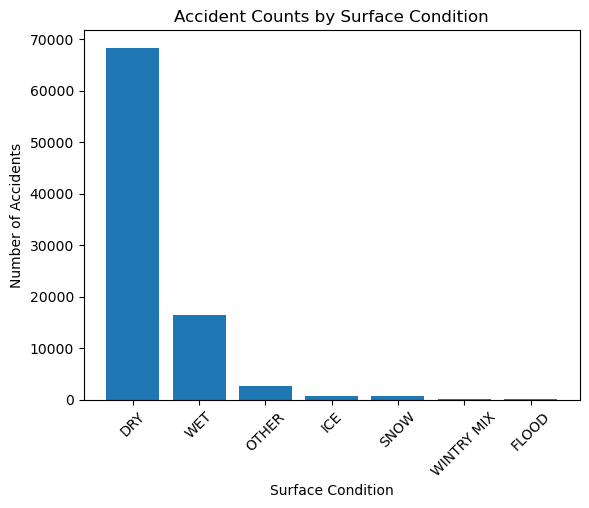

In [58]:
import matplotlib.pyplot as plt

# Accident count by surface condition
surface_condition_counts = df_focused_crashes['Surface Condition'].value_counts()

# Plot accident counts
plt.bar(surface_condition_counts.index, surface_condition_counts.values)
plt.xlabel('Surface Condition')
plt.ylabel('Number of Accidents')
plt.title('Accident Counts by Surface Condition')
plt.xticks(rotation=45)
plt.show()

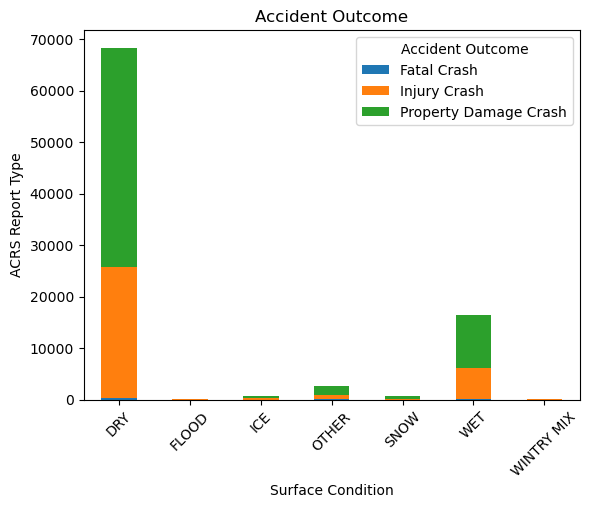

In [59]:
# Injury Severity counts by surface condition
injury_severity_counts = df_focused_crashes.groupby('Surface Condition')['ACRS Report Type'].value_counts().unstack()

# Plot injury severity counts (transpose to get Surface Condition on x-axis)
injury_severity_counts.plot(kind='bar', stacked=True)
plt.xlabel('Surface Condition')
plt.ylabel('ACRS Report Type')
plt.title('Accident Outcome')
plt.xticks(rotation=45)
plt.legend(title='Accident Outcome')
plt.show()

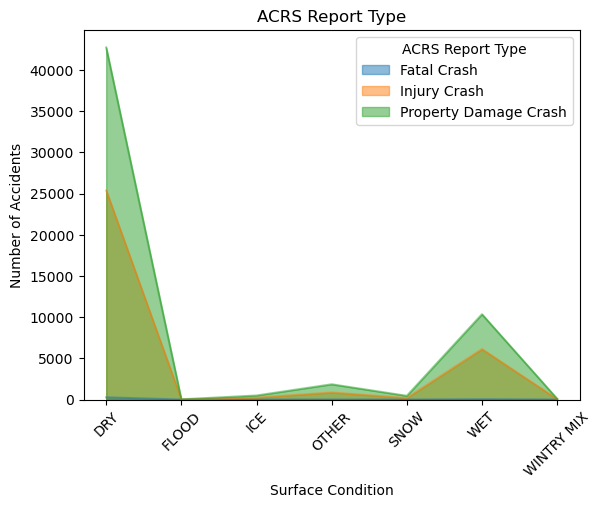

In [60]:
# Injury Severity counts by surface condition
injury_severity_counts = df_focused_crashes.groupby('Surface Condition')['ACRS Report Type'].value_counts().unstack()

# Plot injury severity counts (transpose to get Surface Condition on x-axis)
injury_severity_counts.plot(kind='area', stacked=False)
plt.xlabel('Surface Condition')
plt.ylabel('Number of Accidents')
plt.title('ACRS Report Type')
plt.xticks(rotation=45)
plt.legend(title='ACRS Report Type')
plt.show()

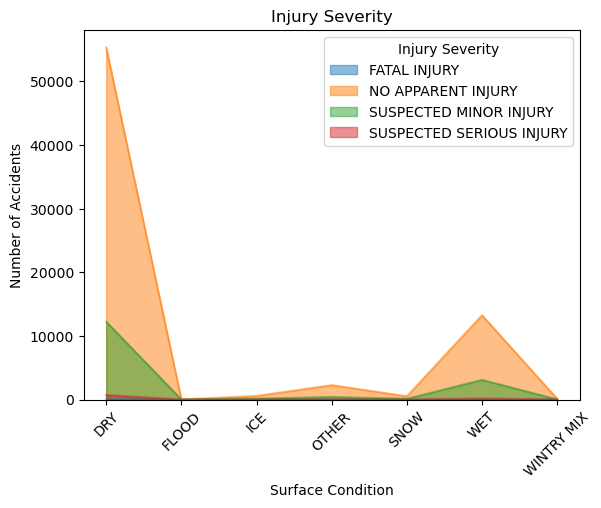

In [61]:
# Injury Severity counts by surface condition
injury_severity_counts = df_focused_crashes.groupby('Surface Condition')['Injury Severity'].value_counts().unstack()

# Plot injury severity counts (transpose to get Surface Condition on x-axis)
injury_severity_counts.plot(kind='area', stacked=False)
plt.xlabel('Surface Condition')
plt.ylabel('Number of Accidents')
plt.title('Injury Severity')
plt.xticks(rotation=45)
plt.legend(title='Injury Severity')
plt.show()

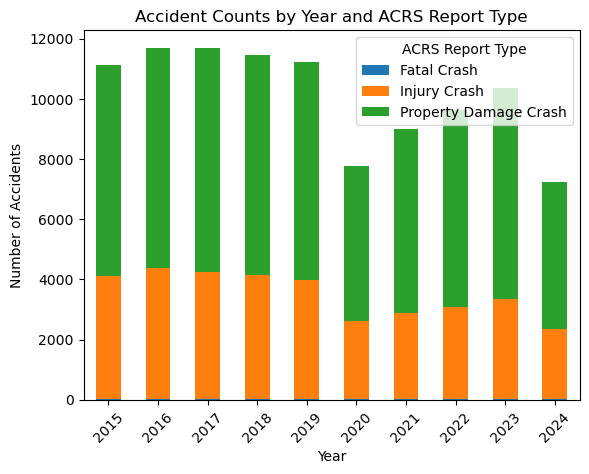

In [62]:
# Create a new column 'Year' from 'Crash Date/Time'
df_focused_crashes['Year'] = pd.to_datetime(df_focused_crashes['Crash Date/Time']).dt.year

# Group by year and ACRS Report Type
grouped_data = df_focused_crashes.groupby(['Year', 'ACRS Report Type']).size().unstack()

# Plot accident counts for each year and ACRS Report Type
grouped_data.plot(kind='bar', stacked=True)
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.title('Accident Counts by Year and ACRS Report Type')
plt.xticks(rotation=45)
plt.legend(title='ACRS Report Type')
plt.show()

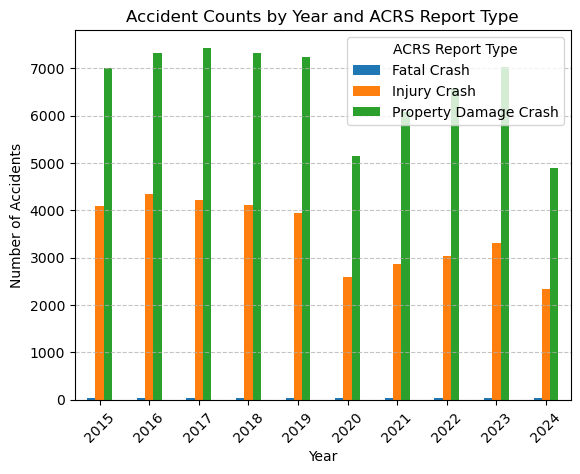

In [63]:
# Create a new column 'Year' from 'Crash Date/Time'
df_focused_crashes['Year'] = pd.to_datetime(df_focused_crashes['Crash Date/Time']).dt.year

# Group by year and ACRS Report Type
grouped_data = df_focused_crashes.groupby(['Year', 'ACRS Report Type']).size().unstack()

# Plot accident counts for each year and ACRS Report Type
grouped_data.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.title('Accident Counts by Year and ACRS Report Type')
plt.xticks(rotation=45)
plt.legend(title='ACRS Report Type')
plt.grid(axis='y', linestyle='--', alpha=0.75)
plt.show()

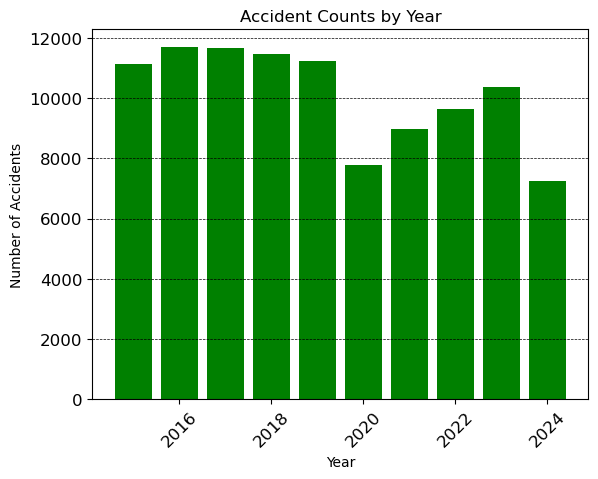

In [64]:
accident_counts_by_year = df_focused_crashes.groupby('Year').size()

# Plot accident counts by year
plt.bar(accident_counts_by_year.index, accident_counts_by_year.values, color='green') 
plt.grid(True, linestyle='--', linewidth=0.5, color='black', which='both', axis='y') 

plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.title('Accident Counts by Year')

plt.xticks(rotation=45, fontsize=12) 
plt.yticks(fontsize=12)  

plt.show()



(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000.]),
 [Text(0, 0.0, '0'),
  Text(0, 10000.0, '10000'),
  Text(0, 20000.0, '20000'),
  Text(0, 30000.0, '30000'),
  Text(0, 40000.0, '40000'),
  Text(0, 50000.0, '50000'),
  Text(0, 60000.0, '60000'),
  Text(0, 70000.0, '70000'),
  Text(0, 80000.0, '80000')])

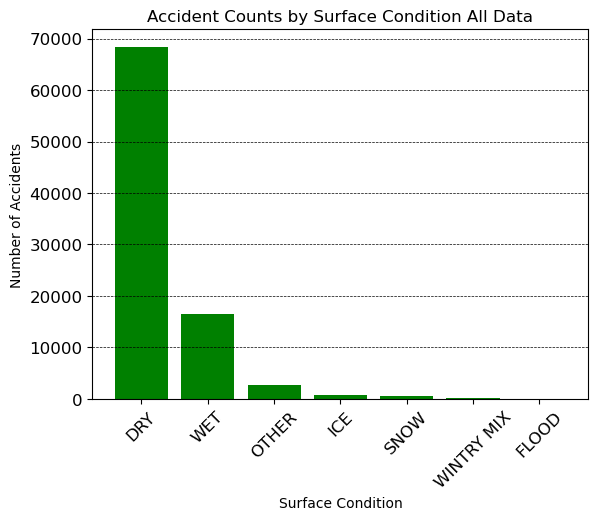

In [65]:
plt.bar(surface_condition_counts.index, surface_condition_counts.values, color='green')
plt.grid(True, linestyle='--', linewidth=0.5, color='black', which='both', axis='y')

plt.xlabel('Surface Condition')
plt.ylabel('Number of Accidents')
plt.title('Accident Counts by Surface Condition All Data')
plt.xticks(rotation=45, fontsize=12) 
plt.yticks(fontsize=13)

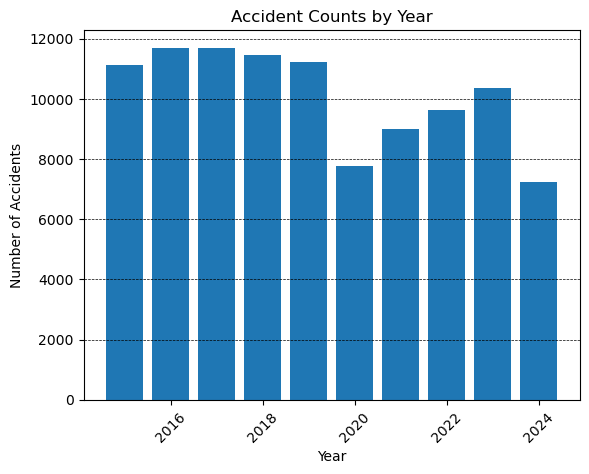

In [66]:
# Create a new column 'Year' from 'Crash Date/Time'
df_focused_crashes['Year'] = pd.to_datetime(df_focused_crashes['Crash Date/Time']).dt.year

# Calculate accident counts by year
accident_counts_by_year = df_focused_crashes.groupby('Year').size()

# Plot accident counts by year
plt.bar(accident_counts_by_year.index, accident_counts_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.title('Accident Counts by Year')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5, color='black', which='both', axis='y')  
plt.show()

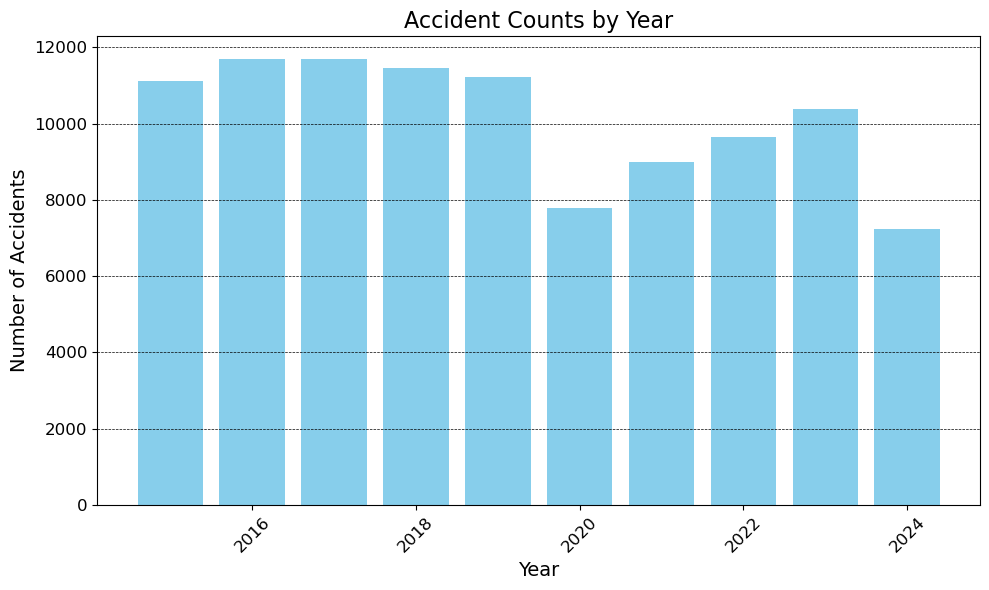

In [68]:
# Calculate accident counts by year
accident_counts_by_year = df_focused_crashes.groupby('Year').size()

# Create a visually appealing bar chart
plt.figure(figsize=(10, 6))  
plt.bar(accident_counts_by_year.index, accident_counts_by_year.values, color='skyblue') 
plt.grid(True, linestyle='--', linewidth=0.5, color='black', which='both', axis='y') 

# Customize labels and title with larger font sizes
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.title('Accident Counts by Year', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12) 

# Adjust y-axis tick label font size
plt.yticks(fontsize=12)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

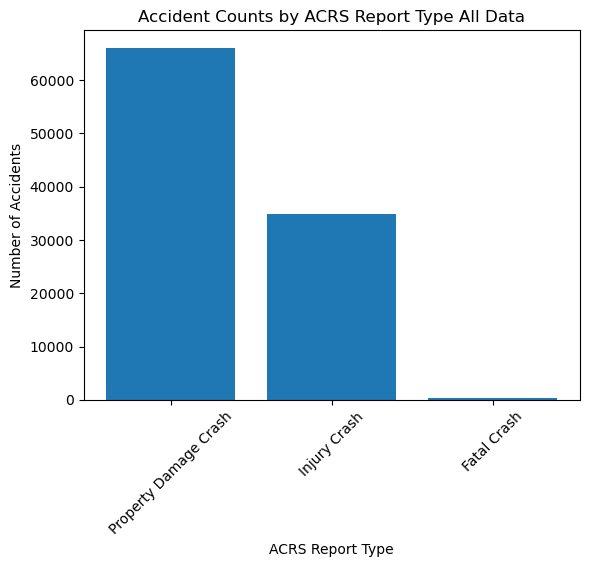

In [67]:
# Accident count by ACRS Report Type
acrs_report_type_counts = df_focused_crashes['ACRS Report Type'].value_counts()

# Plot accident counts
plt.bar(acrs_report_type_counts.index, acrs_report_type_counts.values)
plt.xlabel('ACRS Report Type')
plt.ylabel('Number of Accidents')
plt.title('Accident Counts by ACRS Report Type All Data')
plt.xticks(rotation=45)
plt.show()


In [41]:
# 
montgomery_gdf = gpd.GeoDataFrame(df_focused_crashes, geometry=gpd.points_from_xy(df_focused_crashes.Longitude, df_focused_crashes.Latitude))
montgomery_gdf.crs = 'EPSG:4326'

NameError: name 'gpd' is not defined

In [26]:


# Print correlation
#print(correlation)

SyntaxError: invalid non-printable character U+00A0 (614481751.py, line 11)

In [17]:
montgomery_gdf.plot()

NameError: name 'montgomery_gdf' is not defined

In [18]:
county_gdf = gpd.read_file('../Resources/Montgomery_County.json')

NameError: name 'gpd' is not defined

In [19]:
county_gdf.plot()

NameError: name 'county_gdf' is not defined

In [20]:
data_crash_clip = gpd.clip(montgomery_gdf, county_gdf)

NameError: name 'gpd' is not defined

In [21]:
data_crash_clip.plot()

NameError: name 'data_crash_clip' is not defined

In [22]:
data_crash_clip = data_crash_clip.reset_index()
data_crash_clip.drop(columns=['level_0','index'], inplace=True)
data_crash_clip.info()

NameError: name 'data_crash_clip' is not defined

In [23]:
data_crash_clip.to_csv('../Resources/Montgomery_Crash_Data.csv', index=False)

NameError: name 'data_crash_clip' is not defined